In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import yfinance as yf

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Fetch historical data for the ticker
ticker = "AMZN"
tick = yf.Ticker(ticker)

In [4]:
data = tick.history(period = "max")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


In [5]:
col_name = 'Close'
data = data[[col_name]]
data.head()

,Close
Date,
1997-05-15 00:00:00-04:00,0.097917
1997-05-16 00:00:00-04:00,0.086458
1997-05-19 00:00:00-04:00,0.085417
1997-05-20 00:00:00-04:00,0.081771
1997-05-21 00:00:00-04:00,0.071354


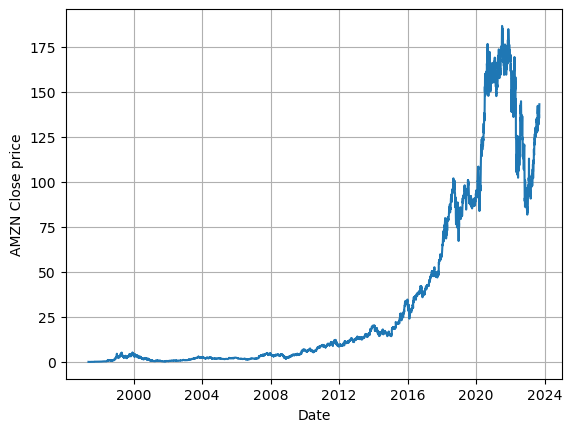

In [6]:
data.index = pd.to_datetime(data.index)

plt.xlabel('Date')
plt.ylabel(f'{ticker} {col_name} price')
plt.plot(data.index, data[col_name])
plt.grid(True)
plt.show()

In [7]:
import copy

def getLags(df, lag, col):
    df = copy.deepcopy(df)
    for i in range(1,lag+1):
        df[f'{col}(t-{i})'] = df[col].shift(i)
    df.dropna(inplace=True)
    
    return df

lag = 7
shifted_df = getLags(data,lag, col = col_name)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27 00:00:00-04:00,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28 00:00:00-04:00,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29 00:00:00-04:00,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30 00:00:00-04:00,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02 00:00:00-04:00,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [8]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_np = shifted_df.to_numpy()
X = x_scaler.fit_transform(shifted_df_np[:,1:])
y = y_scaler.fit_transform(shifted_df_np[:,0].reshape(-1, 1))

print(X.shape,y.shape)

(6617, 7) (6617, 1)


In [9]:
def testTrainSplit(X, y, train_ratio=0.95):
    # Determine the split point
    split_len = int(len(X) * train_ratio)
    
    # Split the data into train and test sets
    X_train = X[:split_len]
    X_test = X[split_len:]
    
    y_train = y[:split_len]
    y_test = y[split_len:]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = testTrainSplit(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6286, 7) (331, 7) (6286, 1) (331, 1)


In [10]:
X_train = torch.tensor(X_train.reshape(-1,lag,1),dtype=torch.float)
X_test = torch.tensor(X_test.reshape(-1,lag,1),dtype=torch.float)

y_train = torch.tensor(y_train.reshape(-1,1),dtype=torch.float)
y_test = torch.tensor(y_test.reshape(-1,1),dtype=torch.float)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([6286, 7, 1]) torch.Size([331, 7, 1]) torch.Size([6286, 1]) torch.Size([331, 1])


In [11]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

In [13]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [14]:
class LSTM(nn.Module):
    
    def __init__(self, n_in, n_hidden, n_layers):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(n_in, n_hidden, n_layers, batch_first = True)
        self.fc = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)
        out, _ = self.lstm(x,(h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        
model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
def train(verbose = False):
    model.train(True)
    losses = torch.zeros(len(train_loader))
    print(f'epoch: {epoch+1},  loss: {losses.mean():.4f}')
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)
        loss = mse_loss(y_pred, y_batch)
        losses[batch_index] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and batch_index % 100 == 99:
            print(f'batch: {batch_index+1}, loss: {losses.mean():.4f}')

In [16]:
def validate():
    model.train(False)
    running_loss = 0.
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            y_pred = model(x_batch)
            loss = mse_loss(y_pred, y_batch)
            running_loss += loss.item()
           
    print(f'validation loss: {running_loss/len(test_loader):.4f}')
    print('****************************************************')

In [17]:
lr = .001
n_epochs = 100
mse_loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

for epoch in range(n_epochs):
    train()
    validate()

epoch: 1,  loss: 0.0000
validation loss: 0.0243
****************************************************
epoch: 2,  loss: 0.0000
validation loss: 0.0105
****************************************************
epoch: 3,  loss: 0.0000
validation loss: 0.0038
****************************************************
epoch: 4,  loss: 0.0000
validation loss: 0.0035
****************************************************
epoch: 5,  loss: 0.0000
validation loss: 0.0036
****************************************************
epoch: 6,  loss: 0.0000
validation loss: 0.0042
****************************************************
epoch: 7,  loss: 0.0000
validation loss: 0.0034
****************************************************
epoch: 8,  loss: 0.0000
validation loss: 0.0034
****************************************************
epoch: 9,  loss: 0.0000
validation loss: 0.0037
****************************************************
epoch: 10,  loss: 0.0000
validation loss: 0.0033
******************************************

validation loss: 0.0016
****************************************************
epoch: 83,  loss: 0.0000
validation loss: 0.0020
****************************************************
epoch: 84,  loss: 0.0000
validation loss: 0.0024
****************************************************
epoch: 85,  loss: 0.0000
validation loss: 0.0021
****************************************************
epoch: 86,  loss: 0.0000
validation loss: 0.0016
****************************************************
epoch: 87,  loss: 0.0000
validation loss: 0.0019
****************************************************
epoch: 88,  loss: 0.0000
validation loss: 0.0016
****************************************************
epoch: 89,  loss: 0.0000
validation loss: 0.0015
****************************************************
epoch: 90,  loss: 0.0000
validation loss: 0.0016
****************************************************
epoch: 91,  loss: 0.0000
validation loss: 0.0017
****************************************************
epoch

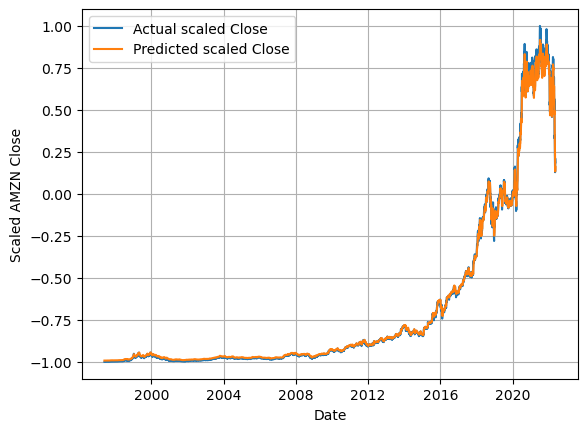

In [18]:
# Check that the model performs well on the training set
with torch.no_grad():
    pred = model(X_train.to(device)).to('cpu').numpy()
    
plt.plot(shifted_df.index[:len(y_train)], y_train, label = f'Actual scaled {col_name}')
plt.plot(shifted_df.index[:len(y_train)], pred, label = f'Predicted scaled {col_name}')
plt.xlabel('Date')
plt.ylabel(f'Scaled {ticker} {col_name}')
plt.legend()
plt.grid(True)
plt.show()

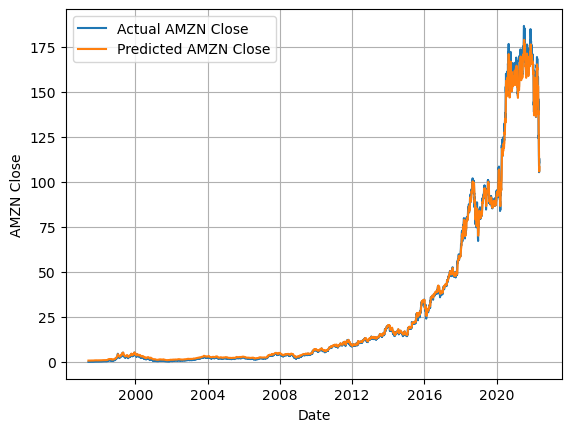

In [19]:
# Recover the original scaling and plot the predictions on training data
pred = y_scaler.inverse_transform(pred)
y = y_scaler.inverse_transform(y_train)

plt.plot(shifted_df.index[:len(y_train)], y, label= f'Actual {ticker} {col_name}')
plt.plot(shifted_df.index[:len(y_train)], pred, label= f'Predicted {ticker} {col_name}')
plt.xlabel('Date')
plt.ylabel(f'{ticker} Close')
plt.legend()
plt.grid(True)
plt.show()

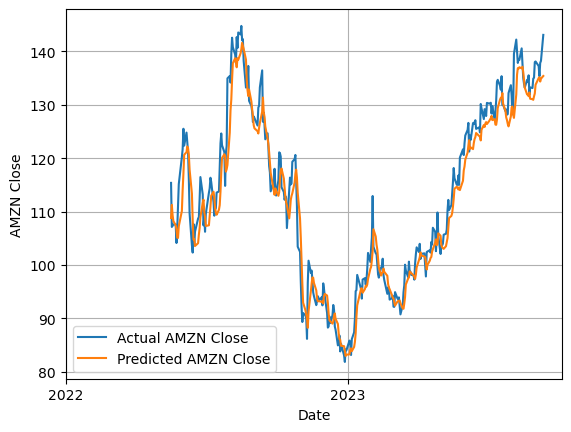

In [20]:
# Make predictions using the model on the test data
with torch.no_grad():
    pred = model(X_test.to(device)).cpu().numpy()

pred = y_scaler.inverse_transform(pred)
y = y_scaler.inverse_transform(y_test)

dates = shifted_df.index[-len(y):]

plt.plot(dates, y, label= f'Actual {ticker} {col_name}')
plt.plot(dates, pred, label= f'Predicted {ticker} {col_name}')
plt.xlabel('Date')
plt.ylabel(f'{ticker} Close')
plt.legend()
plt.grid(True)

plt.gca().set_xticks([datetime.date(year, 1, 1) for year in set(date.year for date in dates)])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()